In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy
import torch.nn.functional as func

In [3]:
import pickle
import matplotlib.pyplot as plt

f = open("MNIST", "rb")
data = pickle.load(f)
f.close()
print("Training Set Size:", len(data["train"]))
print("Testing Set Size:", len(data["test"]))


#plt.imshow(data["train"][0]["image"], cmap="Greys")
#plt.colorbar()
#plt.show()

Training Set Size: 60000
Testing Set Size: 10000


In [4]:
type(data["train"][0]["image"])

numpy.ndarray

In [5]:
# Convert data into tensors
x_train = []
for i in range(len(data["train"])):
    x_train.append(torch.FloatTensor(data["train"][i]["image"]))

x_train = torch.stack(x_train)

#print(type(x_train))
#print(type(x_train[0]))
#print(x_train.shape)

y_train = []
for j in range(len(data["train"])):
    y_train.append(data["train"][j]["label"])

y_train = torch.Tensor(y_train)
#print(type(y_train))
#print(type(y_train[0]))
#print(y_train.shape)

x_test = []
for a in range(len(data["test"])):
    x_test.append(torch.FloatTensor(data["test"][a]["image"]))

x_test = torch.stack(x_test)

#print(type(x_train))
#print(type(x_train[0]))
#print(x_train.shape)

y_test = []
for b in range(len(data["test"])):
    y_test.append(data["test"][b]["label"])

y_test = torch.Tensor(y_test)


In [6]:
#y_train = func.one_hot(y_train.long(), num_classes=10)
#y_train.shape

In [7]:
y_train

tensor([5., 0., 4.,  ..., 5., 6., 8.])

In [8]:
x_train[0].shape

torch.Size([28, 28])

In [9]:
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, x, y):
        # Init
        self.x = x
        self.y = y

        # Normalize between 0 and 1
        self.x = self.x / 255.

        #One Hot Encoding
        self.y = func.one_hot(self.y.long(), num_classes=10).to(float)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]

In [10]:
trainingDS = TensorDataset(x_train, y_train)
testingDS = TensorDataset(x_test, y_test)

In [11]:
trainingDL = DataLoader(trainingDS, batch_size=20)
testingDL = DataLoader(testingDS, batch_size=20)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 256)
        self.Matrix2 = nn.Linear(256, 128)
        self.Matrix3 = nn.Linear(128,64)
        self.Matrix4 = nn.Linear(64, 10)
        self.R = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.R(self.Matrix3(x))
        x = self.Matrix4(x)
        return x.squeeze()

In [13]:
f = CNN()

In [14]:
import numpy as np
from torch.optim import SGD

def train_model(trainingDL, f, n_epochs=20):
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    losses = []
    epochs = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(trainingDL)
        for i, (x, y) in enumerate(trainingDL):
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [15]:
epoch_data, loss_data = train_model(trainingDL, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

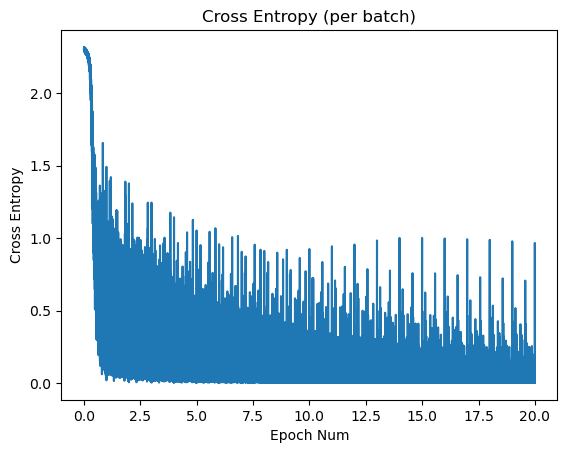

In [16]:
plt.plot(epoch_data, loss_data)
plt.xlabel("Epoch Num")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (per batch)")

In [17]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avg per epoch)')

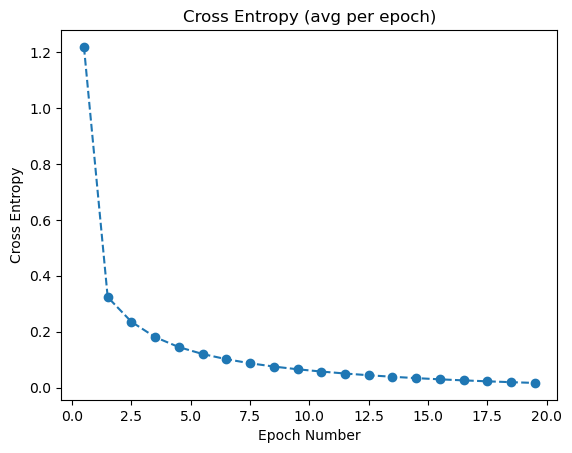

In [18]:
plt.plot(epoch_data_avgd, loss_data_avgd, "o--")
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (avg per epoch)")

In [19]:
trainingDS[0][1]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [23]:
x_sample = trainingDS[0][0]
yhat_sample = f(x_sample)
yhat_sample

tensor([ -1.2338,  -1.4464,  -2.1276,  17.5950, -17.4739,  20.7827, -10.5314,
         -4.3041,   1.5294,   3.1869], grad_fn=<SqueezeBackward0>)

In [21]:
torch.argmax(yhat_sample)

tensor(5)

In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,6,5)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16*4*4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84,10)


    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [78]:
with torch.no_grad():
    #f.eval()
    numCorrect = 0
    for (x, y) in testingDL:
        pred = f(x)
        print("Predicted: ", torch.argmax(pred), " Actual: ", torch.argmax(y))
        if torch.argmax(pred) == torch.argmax(y):
            numCorrect += 1
    print(len(testingDL))
    print(numCorrect)

Predicted:  tensor(99)  Actual:  tensor(7)
Predicted:  tensor(103)  Actual:  tensor(9)
Predicted:  tensor(84)  Actual:  tensor(1)
Predicted:  tensor(83)  Actual:  tensor(7)
Predicted:  tensor(54)  Actual:  tensor(7)
Predicted:  tensor(25)  Actual:  tensor(6)
Predicted:  tensor(125)  Actual:  tensor(5)
Predicted:  tensor(155)  Actual:  tensor(6)
Predicted:  tensor(25)  Actual:  tensor(4)
Predicted:  tensor(80)  Actual:  tensor(1)
Predicted:  tensor(163)  Actual:  tensor(3)
Predicted:  tensor(184)  Actual:  tensor(7)
Predicted:  tensor(104)  Actual:  tensor(5)
Predicted:  tensor(103)  Actual:  tensor(8)
Predicted:  tensor(160)  Actual:  tensor(2)
Predicted:  tensor(84)  Actual:  tensor(4)
Predicted:  tensor(135)  Actual:  tensor(9)
Predicted:  tensor(115)  Actual:  tensor(5)
Predicted:  tensor(155)  Actual:  tensor(4)
Predicted:  tensor(155)  Actual:  tensor(0)
Predicted:  tensor(125)  Actual:  tensor(2)
Predicted:  tensor(173)  Actual:  tensor(4)
Predicted:  tensor(113)  Actual:  tensor

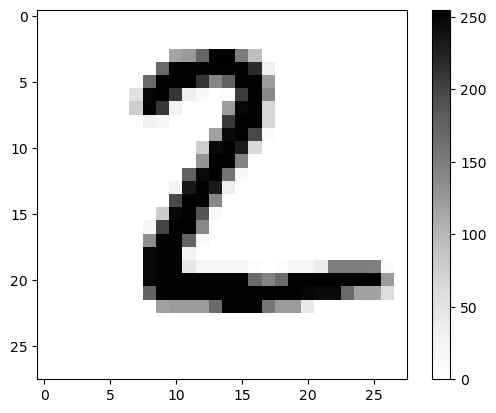

In [80]:
plt.imshow(data["test"][1]["image"], cmap="Greys")
plt.colorbar()
plt.show()